In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras import optimizers,constraints,losses,callbacks
from tensorflow.keras import (layers,Model,Input)
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from random import seed
from tensorflow.random import set_seed

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/fifa-20-complete-player-dataset/players_15.csv
/kaggle/input/fifa-20-complete-player-dataset/players_16.csv
/kaggle/input/fifa-20-complete-player-dataset/players_17.csv
/kaggle/input/fifa-20-complete-player-dataset/players_18.csv
/kaggle/input/fifa-20-complete-player-dataset/players_19.csv
/kaggle/input/fifa-20-complete-player-dataset/teams_and_leagues.csv
/kaggle/input/fifa-20-complete-player-dataset/players_20.csv


# Funciones para utilizar posteriormente

In [2]:
def set_random_seed(random_seed=None):
    
    """
    Esta función se utiliza para establecer la semilla aleatoria en diferentes bibliotecas y entornos.
    Toma un parámetro opcional random_seed que se utiliza como semilla aleatoria.
    La función utiliza otras funciones como set_seed de alguna biblioteca (no se proporciona en el código)
    y las funciones np.random.seed y seed de la biblioteca NumPy y Python respectivamente,
    para establecer la semilla en diferentes componentes del entorno.
    """
    
    # Establecer la semilla aleatoria en diferentes bibliotecas y entornos
    set_seed(random_seed)  # Función para establecer la semilla en alguna biblioteca (no proporcionada en el código)
    np.random.seed(random_seed)  # Establecer la semilla aleatoria en NumPy
    seed(random_seed)  # Establecer la semilla aleatoria en Python

def linear_regression(input_shape, optimizer, loss, metrics=None, **kwargs):
    
    """
    Esta función crea un modelo de regresión lineal utilizando la biblioteca 
    Keras.
    Toma los siguientes parámetros:
    
    - input_shape: La forma de los datos de entrada para el modelo.
    
    - optimizer: El optimizador que se utilizará durante el entrenamiento del modelo.
    - loss: La función de pérdida que se utilizará durante el entrenamiento del modelo.
    - metrics: Una lista opcional de métricas para evaluar el rendimiento del modelo durante el entrenamiento.
    - **kwargs: Argumentos adicionales que se pueden pasar a la capa Dense de Keras.

    En el código, primero se borra la sesión actual utilizando clear_session().
    Luego se define una capa de entrada utilizando la forma especificada por input_shape.
    A continuación, se crea una capa Dense con una unidad de salida (1) y una función de activación lineal ('linear').
    Los argumentos adicionales (**kwargs) se pasan a la capa Dense.
    Luego se crea un modelo utilizando las capas de entrada y salida definidas.
    El modelo se compila utilizando el optimizador, la función de pérdida y las métricas especificadas.
    Finalmente, se devuelve el modelo.
    """
    
    
    clear_session()  # Limpiar la sesión actual
    
    inputs = Input(shape=input_shape)  # Capa de entrada con la forma especificada
    outputs = layers.Dense(1, 'linear', **kwargs)(inputs)  # Capa de salida lineal
    
    model = Model(inputs=inputs, outputs=outputs)  # Crear el modelo
    
    model.compile(optimizer, loss, metrics)  # Compilar el modelo
    
    return model

def preprocessing_data(df, features, scaler):
    
    '''
    Esta función se utiliza para realizar el preprocesamiento de datos en un 
    DataFrame. Toma los siguientes parámetros:

    -df: El DataFrame que contiene los datos.
    
    -features: Una lista de nombres de columnas que se utilizarán como 
    características de entrada.
    
    -scaler: Un objeto de escalador que se utilizará para escalar los datos.
    
    En el código, primero se seleccionan las columnas especificadas por 
    features del DataFrame df y se almacenan en X. 
    Luego se ajusta el escalador (scaler) utilizando los datos X. 
    A continuación, se transforma (transform) el conjunto de datos 
    X utilizando el escalador ajustado, y se almacena el resultado en X_t. 
    Finalmente, se devuelve X_t y el objeto escalador scaler.
    
    '''
    
    
    X = df[features]  # Seleccionar las columnas de características
    
    scaler.fit(X)  # Ajustar el escalador a los datos
    
    X_t = scaler.transform(X)  # Transformar los datos utilizando el escalador ajustado
    
    return X_t, scaler

# Carga de los datos y escalado

In [3]:
# Cargar el archivo CSV en un DataFrame usando pandas
fifa_20 = pd.read_csv('/kaggle/input/fifa-20-complete-player-dataset/players_20.csv')

# Seleccionar las características y el objetivo
features = list(fifa_20.columns[fifa_20.dtypes == 'int64'])[11:]  # Lista de características
target = ['overall']  # variable respuesta o etiquetas

# Crear un objeto escalador
scaler_data = MinMaxScaler()

# Preprocesar los datos utilizando la función preprocessing_data
X_t, scaler_data = preprocessing_data(fifa_20, features, scaler_data)

# Obtener los valores del objetivo y asignarlos a 'y'

# PCA

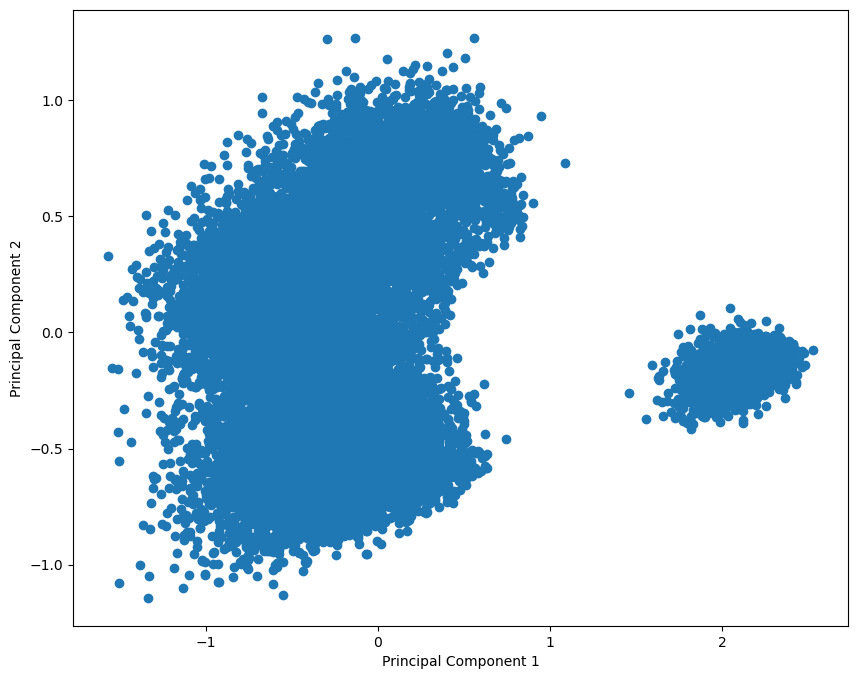

In [4]:
# Crear un objeto PCA
pca = PCA()

# Ajustar el objeto PCA a los datos escalados X_t
pca.fit(X_t)

# Realizar la transformación PCA en los datos X_t y seleccionar las primeras dos componentes principales
X_pca = pca.transform(X_t)[:, :2]

# Crear una figura de tamaño 10x8
plt.figure(figsize=(10, 8))

# Graficar los puntos en el plano de las dos primeras componentes principales
plt.scatter(X_pca[:, 0], X_pca[:, 1])

# Establecer las etiquetas de los ejes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Mostrar el gráfico
plt.plot()
plt.show()

# K-Medias utilizando el PCA

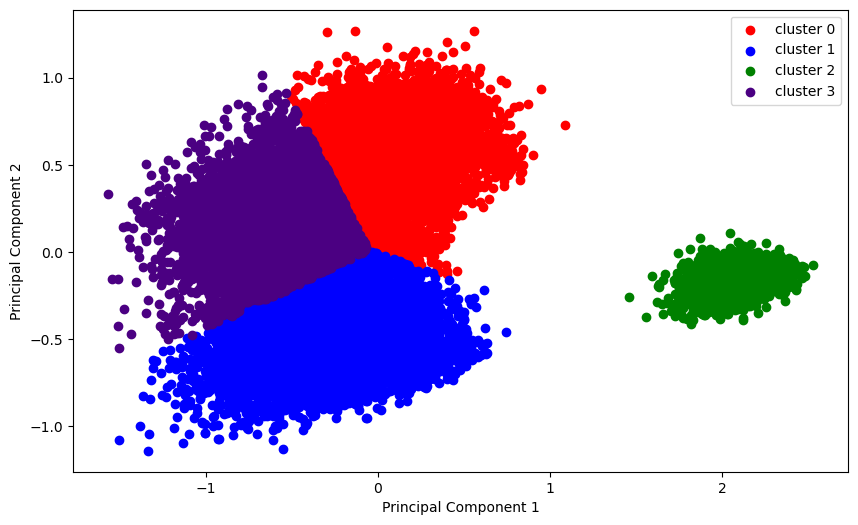

In [5]:
# Crear un objeto KMeans con 4 clusters y una semilla aleatoria de 1
kmeans = KMeans(n_clusters=4, random_state=1)

# Ajustar el modelo KMeans a los datos X_pca
kmeans.fit(X_pca)

# Predecir los clusters para los datos X_pca
clusters = kmeans.predict(X_pca)

# Agregar una columna 'cluster' al DataFrame fifa_20 con los clusters asignados
fifa_20['cluster'] = clusters

# Definir los colores para cada cluster
colors = ['red', 'blue', 'green', 'indigo', 'olive']

# Crear una figura de tamaño 10x6
plt.figure(figsize=(10, 6))

# Graficar los puntos de cada cluster en el plano de las dos primeras componentes principales
for c, col in zip(np.unique(clusters), colors):
    plt.scatter(X_pca[clusters == c, 0], X_pca[clusters == c, 1], c=col, label='cluster {}'.format(c))

# Establecer las etiquetas de los ejes y la leyenda
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Mostrar el gráfico
plt.plot()
plt.show()

# Identificando los clusters

In [6]:
# Seleccionar las columnas 'short_name', 'cluster' y 'player_positions' del DataFrame fifa_20
# Filtrar las filas donde el valor de 'cluster' sea igual a 0
# Mostrar las primeras 20 filas resultantes
fifa_20[['short_name', 'cluster', 'player_positions']].query('cluster==0').head(20)

,short_name,cluster,player_positions
11,K. Koulibaly,0,CB
57,M. Škriniar,0,CB
77,N. Süle,0,CB
83,J. Giménez,0,CB
90,K. Manolas,0,CB
126,S. de Vrij,0,CB
133,Sokratis,0,CB
156,Felipe,0,CB
158,A. Romagnoli,0,CB
165,J. Tah,0,CB


In [7]:
fifa_20[['short_name','cluster','player_positions','overall']].query('cluster==1').sort_values('overall').tail(20)

,short_name,cluster,player_positions,overall
54,L. Insigne,1,"CF, LW, ST",87
48,D. Mertens,1,"CF, ST",87
46,K. Benzema,1,"CF, ST",87
23,P. Dybala,1,"CAM, RW",88
26,R. Sterling,1,"RW, LW",88
27,C. Eriksen,1,"CAM, CM",88
37,M. Reus,1,"CAM, LM, ST",88
38,P. Aubameyang,1,"ST, LM",88
39,S. Mané,1,"LW, LM",88
33,David Silva,1,"CAM, CM",88


In [8]:
fifa_20[['short_name','cluster','nationality','player_positions']].query('cluster==2').head(20)

,short_name,cluster,nationality,player_positions
3,J. Oblak,2,Slovenia,GK
6,M. ter Stegen,2,Germany,GK
13,Alisson,2,Brazil,GK
14,De Gea,2,Spain,GK
25,Ederson,2,Brazil,GK
28,T. Courtois,2,Belgium,GK
30,S. Handanovič,2,Slovenia,GK
31,M. Neuer,2,Germany,GK
32,H. Lloris,2,France,GK
53,K. Navas,2,Costa Rica,GK


In [9]:
fifa_20[['short_name','cluster','nationality','player_positions']].query('cluster==3').head(20)

,short_name,cluster,nationality,player_positions
5,K. De Bruyne,3,Belgium,"CAM, CM"
7,V. van Dijk,3,Netherlands,CB
8,L. Modrić,3,Croatia,CM
15,N. Kanté,3,France,"CDM, CM"
16,G. Chiellini,3,Italy,CB
18,Sergio Ramos,3,Spain,CB
21,Sergio Busquets,3,Spain,"CDM, CM"
22,A. Griezmann,3,France,"CF, ST, LW"
24,P. Pogba,3,France,"CM, CDM"
29,Piqué,3,Spain,CB


Aunque en algunos casos no agrupa de manera adecuada, podemos identificar que los clusters 0, 1, 2 y 3 hacen referencia respectivamente a las posiciones de defensa, delantero, portero y mediocampista.

In [10]:
# Remplazamos los valores de cada cluster por las posiciones

fifa_20 = fifa_20.replace({'cluster':{0:'DEF',1:'DEL',2:'POR',3:'MED'}})

# Modelo para ajustar una regresión lineal

In [14]:
def fit_model(Position, Learning_rate=0.05, Epochs=100):
    """
    Ajusta un modelo para una posición específica utilizando los datos de entrenamiento.

    Args:
    - Position: Posición específica para la cual se ajustará el modelo.
    - Learning_rate: Tasa de aprendizaje del optimizador (por defecto: 0.05).
    - Epochs: Número de épocas de entrenamiento (por defecto: 100).

    Returns:
    - Modelo entrenado, historial de entrenamiento y objeto escalador.
    """

    # Establecer la semilla aleatoria
    set_random_seed(100)

    # Definir la función de pérdida, el optimizador y la restricción
    loss = losses.MeanSquaredError()
    optimizer = optimizers.SGD(learning_rate=Learning_rate)
    constraint = constraints.NonNeg()

    # Tamaño de prueba para la validación
    test_size = 0.1

    # Filtrar los datos del cluster correspondiente a la posición específica
    data = fifa_20[fifa_20['cluster'] == Position]

    # Crear un objeto escalador
    scaler_pos = MinMaxScaler()

    # Preprocesar los datos utilizando la función preprocessing_data
    X, scaler_pos = preprocessing_data(data, features, scaler_pos)

    # Obtener los valores del objetivo
    y = data[target].values

    # Definir el tamaño del lote (batch_size) y la forma de entrada (input_shape)
    batch_size = round(X.shape[0] / 50)
    input_shape = X.shape[1]

    # Crear el modelo de regresión lineal utilizando la función linear_regression
    model_pos = linear_regression(input_shape, optimizer, loss, kernel_constraint=constraint, use_bias=True)

    # Entrenar el modelo utilizando los datos de entrada (X) y los valores del objetivo (y)
    history_pos = model_pos.fit(X, y, validation_split=test_size, epochs=Epochs, batch_size=batch_size, verbose=0)

    # Devolver el modelo entrenado, el historial de entrenamiento y el objeto escalador
    return model_pos, history_pos, scaler_pos


# Ajustado un modelo para cada una de las posiciones

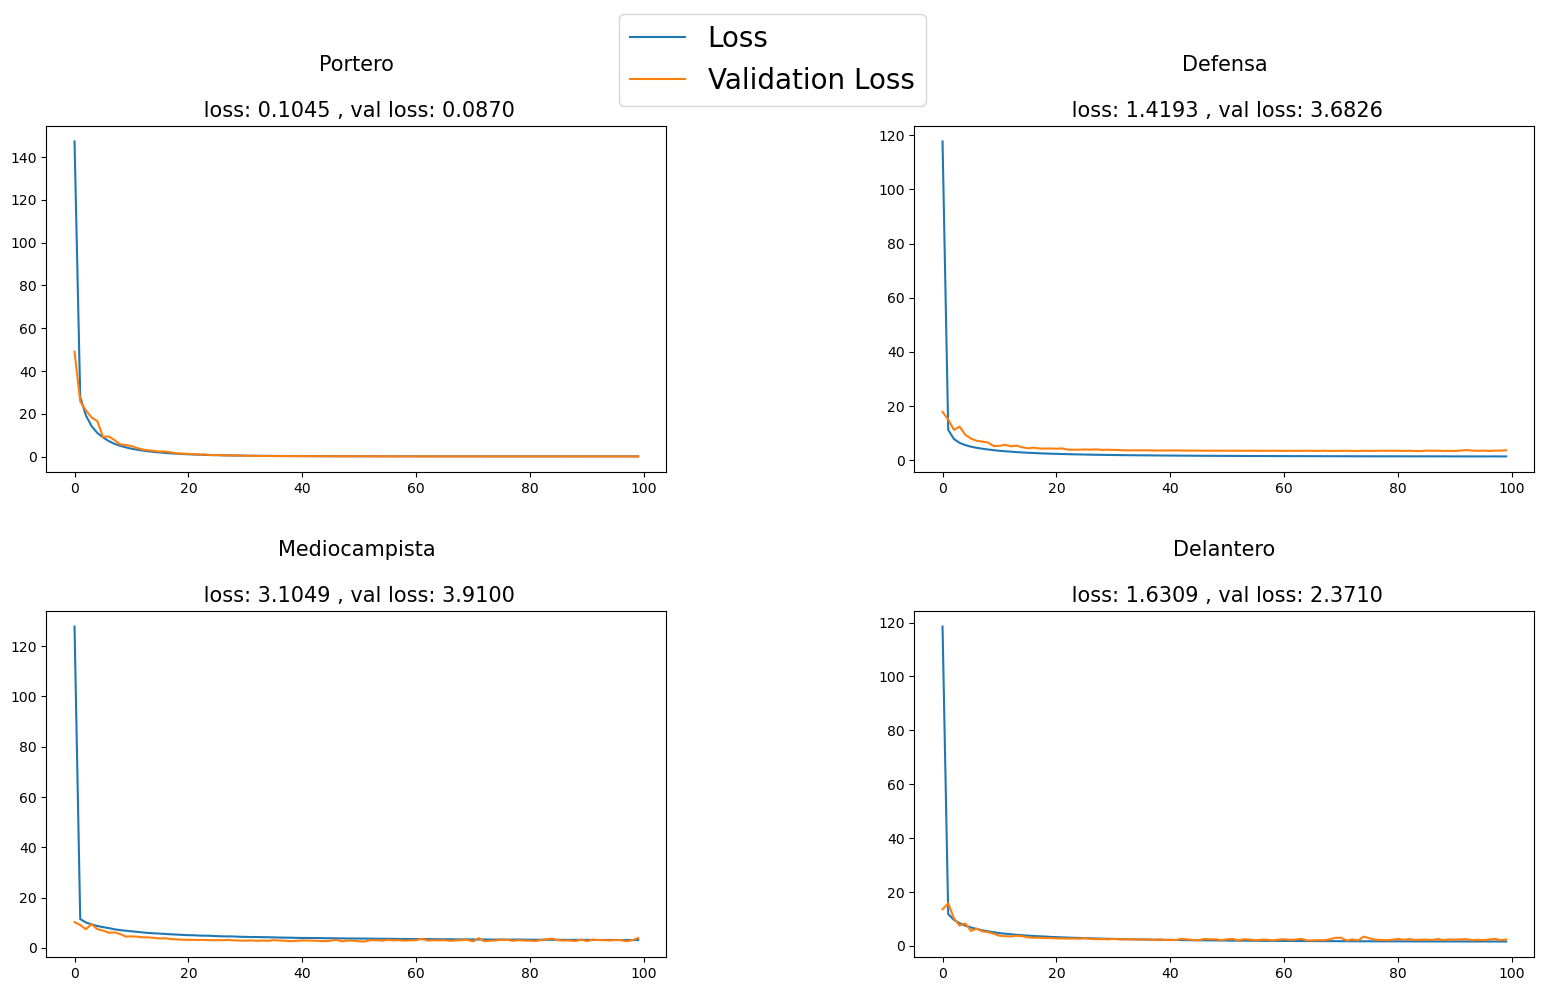

In [24]:
# Definición de un diccionario vacío para almacenar los modelos por posición
models_for_position = {}

# Creación de una figura y ejes con un arreglo 2x2
fig, ax = plt.subplots(2, 2, figsize=(19.20, 10.80))

# Ajuste de los espacios entre los subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Definición de las abreviaturas de las posiciones
positions_short = ['POR', 'DEF', 'MED', 'DEL']

# Definición de las descripciones completas de las posiciones
positions_large = ['Portero', 'Defensa', 'Mediocampista', 'Delantero']

# Iteración sobre las abreviaturas, descripciones y ejes
for ps, pl, a in zip(positions_short, positions_large, ax.flatten()):
    
    # Ajuste del modelo, historial y escala para la posición actual
    model_, history_, scaler_ = fit_model(ps)
    
    # Almacenamiento del modelo y escala en el diccionario
    models_for_position[ps] = (model_, scaler_)
    
    # Creación de un DataFrame a partir del historial y trazado del gráfico de la función pérdida
    pd.DataFrame(history_.history).plot(legend=False, ax=a)
    
    # Configuración del título del subplot con la descripción y las métricas 
    a.set_title('{}\n\n loss: {:.4f}, val loss: {:.4f}'.format(pl, history_.history['loss'][-1], history_.history['val_loss'][-1]),
               fontdict={'size': 15})

# Creación de una leyenda 
fig.legend(['Loss', 'Validation Loss'], fontsize=20, loc='upper center')

# Mostrar la figura
plt.show()

# Probando los modelos utilizando el dataset de FIFA 19

In [34]:
fifa_19 = pd.read_csv('/kaggle/input/fifa-20-complete-player-dataset/players_19.csv')

X_fifa19 = fifa_19[features]

# Limpiando los datos

In [35]:
def clean_data(data):
    """
    Limpia los datos .

    Args:
    - data: DataFrame que se va a limpiar.

    Returns:
    - DataFrame limpio.
    """

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Se obtiene la partición antes del primer '+' y luego se obtiene la partición antes del primer '-'
            data.iloc[i, j] = (data.iloc[i, j].partition('+')[0]).partition('-')[0]

    return data

# Limpieza de los datos en X_fifa19
X_fifa19 = clean_data(X_fifa19)

# Escalando los datos y prediciendo las posiciones

In [37]:
# Transformar los datos utilizando el objeto escalador
X_19_t = scaler_data.transform(X_fifa19)

# Aplicar la transformación PCA a los datos
X_19_pca = pca.transform(X_19_t)[:, :2]

# Predecir las posiciones utilizando el algoritmo de agrupamiento (k-means)
fifa_19['position'] = kmeans.predict(X_19_pca)

X_fifa19['position'] = fifa_19['position'].values

# Reemplazar los valores numéricos de posición por las etiquetas correspondientes
fifa_19 = fifa_19.replace({'position': {0: 'DEF', 1: 'DEL', 2: 'POR', 3: 'MED'}})

X_fifa19 = X_fifa19.replace({'position': {0: 'DEF', 1: 'DEL', 2: 'POR', 3: 'MED'}})

In [38]:
# Inicializar la columna 'predicted overall' en X_fifa19 con valor 0
X_fifa19['predicted overall'] = 0

# Iterar sobre las posiciones en models_for_position
for pos in models_for_position.keys():
    # Obtener los datos correspondientes a la posición actual y eliminar las columnas 'position' y 'predicted overall'
    x = X_fifa19.groupby(['position']).get_group(pos).drop(['position', 'predicted overall'], axis=1)
    
    # Aplicar la transformación a los datos utilizando el objeto escalador correspondiente a la posición actual
    x_t = models_for_position[pos][1].transform(x)
    
    # Predecir el valor de 'predicted overall' utilizando el modelo correspondiente a la posición actual
    X_fifa19.loc[x.index, 'predicted overall'] = models_for_position[pos][0].predict(x_t)

# Redondear los valores de 'predicted overall' en fifa_19
fifa_19['predicted overall'] = X_fifa19['predicted overall'].round()


191/191 [==============================] - 0s 1ms/step


# Predcciones para los jugadores de México

In [40]:
mexico_data = fifa_19.query('nationality=="Mexico"')
mexico_data[['short_name','overall','predicted overall','position']].head(50)

,short_name,overall,predicted overall,position
280,A. Guardado,82,82.0,MED
347,J. Corona,81,81.0,DEL
363,H. Herrera,81,80.0,MED
371,C. Vela,81,81.0,DEL
414,H. Lozano,80,79.0,DEL
658,J. Hernández,79,78.0,DEL
822,R. Jiménez,78,78.0,DEL
882,M. Layún,78,79.0,MED
898,E. Hernández,78,77.0,DEL
899,M. Fabián,78,77.0,DEL
